# MO1 Aggregate 3 (Official)

In [1]:
import load_stl
import meshio
import os.path
import sys
import vtk
from vtk.util.numpy_support import vtk_to_numpy
import numpy as np
import basic_functions as bf
import test_image_ellipsoid as tie
import bounding_box as bbox
import plot
import included_ellipsoid as ie
import bounding_ellipsoid as be
import scipy as scipy
from scipy import optimize
from scipy.optimize import minimize
from scipy.special import ellipkinc, ellipeinc
from importlib import reload
import indicators_calculation as ic

## 1) Load aggregate

In [2]:
load_stl.load_aggregate('C:\\Users\\dschmidt\\Documents\\GitHub\\Cuttings\\MO1_Agg3_Official.stl')

Number of points: 797343
Number of elements:
  triangle: 1603426

In [2]:
reader = vtk.vtkGenericDataObjectReader()
reader.SetFileName('MO1_Agg3_Official.vtk')
reader.Update()

aggregate_coord = np.array(reader.GetOutput().GetPoints().GetData())
print(aggregate_coord)
aggregate_coord = aggregate_coord - bf.compute_center(aggregate_coord)

[[0.004268 0.012134 0.004844]
 [0.004251 0.012138 0.004844]
 [0.004268 0.012138 0.004842]
 ...
 [0.00362  0.017756 0.011147]
 [0.00362  0.017774 0.011148]
 [0.003638 0.017774 0.011148]]


In [4]:
print(aggregate_coord.shape)

(797343, 3)


## 2) Bounding box

TypeError: 'float' object cannot be interpreted as an integer

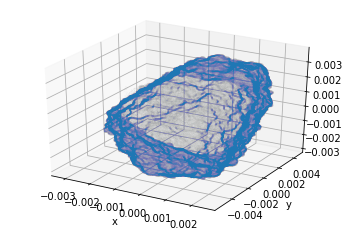

In [3]:
reload(plot)
bbox_aggregate = bbox.bbox_optim(aggregate_coord)
plot.bbox_plot(aggregate_coord, bbox_aggregate, 0.0001)

In [6]:
print(bbox_aggregate)

{'angles': array([ 0.32348805, -0.16884194]), 'volume': 3.19721648199248e-07}


## 3) Bounding ellipsoid

In [4]:
bounding_ellipsoid = be.bounding_ellipsoid_optim(aggregate_coord, 1e-13)

In [11]:
print(bounding_ellipsoid)

{'volume': 3.1704208148574313e-07, 'a': 0.0034034971573674525, 'b': 0.006362611732653254, 'c': 0.0034951634254866528, 'bbox': {'angles': array([ 0.32348805, -0.16884194]), 'volume': 3.19721648199248e-07}}


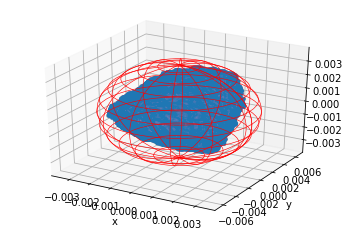

In [12]:
reload(plot)
rotated_aggregate = bf.rotate_aggregate(aggregate_coord,
                                        angles=bounding_ellipsoid['bbox']['angles'])
ax = plot.fit_ellipsoid_plot(rotated_aggregate, bounding_ellipsoid, 0.0001)

## 4) Included ellipsoid

In [5]:
included_ellipsoid = ie.included_ellipsoid_optim(aggregate_coord, 1e-13)

In [14]:
print(included_ellipsoid)

{'volume': 1.716949760714666e-08, 'a': 0.0012876730841425085, 'b': 0.002407219249545089, 'c': 0.0013223539376068269, 'bbox': {'angles': array([ 0.32348805, -0.16884194]), 'volume': 3.19721648199248e-07}}


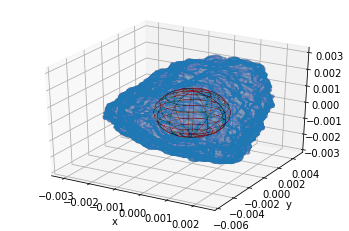

In [15]:
reload(plot)
rotated_aggregate = bf.rotate_aggregate(aggregate_coord,
                                        angles=included_ellipsoid['bbox']['angles'])
ax = plot.fit_ellipsoid_plot(rotated_aggregate, included_ellipsoid, 0.0001)

## 5) Middle ellipsoid

In [6]:
middle_ellipsoid = bf.mid_ellipsoid(bounding_ellipsoid, included_ellipsoid)

In [17]:
print(middle_ellipsoid)

{'volume': 1.0377537897261049e-07, 'a': 0.0023455851207549805, 'b': 0.004384915491099171, 'c': 0.0024087586815467396}


## 6) Indicators

In [15]:
reload(ic)
reload(bf)
reload(plot)

<module 'plot' from 'C:\\Users\\dschmidt\\Documents\\GitHub\\Cuttings\\plot.py'>

In [7]:
distance = ic.roughness_distance(aggregate_coord, middle_ellipsoid)

In [8]:
tomo_surface = 0.00017493939
tomo_volume = 1.2410058e-007 

Aggregate standard sphericity =  0.6877739525282099
Bounding box and ellispoids ratios :
a/b = 0.5349213971207025
a/c = 0.9737733957013935
b/c = 1.8204046443886523
a^2/bc = 0.5208922253075602
Bounding ellipsoid surface / Included ellipsoid surface = 6.986176422464078
Aggregate tomographed surface / Bounding ellipsoid surface = 0.7334761184431103
Aggregate tomographed surface / Middle ellipsoid surface = 1.5443095830589852
Aggregate tomographed surface / Included ellipsoid surface = 5.124193565107728
Roughness map (middle ellipsoid): 
Mean absolute roughness distance = 0.00044425694992539347
Roughness distance min and max [-0.0017650393729036792, 0.0018932355419627885]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

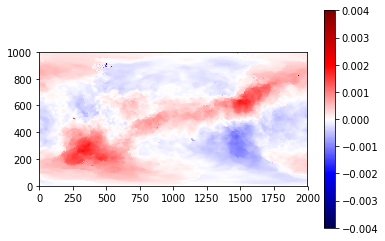

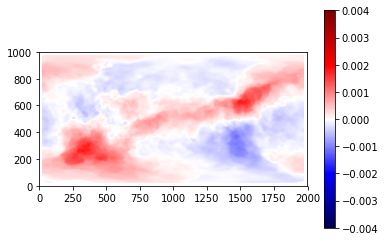

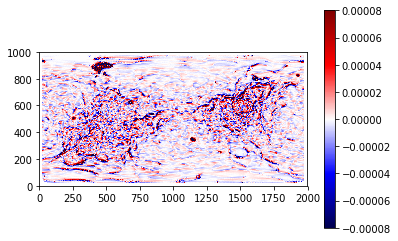

Mean absolute gaussian filtered roughness distance = 1.2814687251360607e-05
Gaussian filtered roughness distance min and max [-0.005203420882494289, 0.005381031759853248]
Roughness histogram (unfiltered)


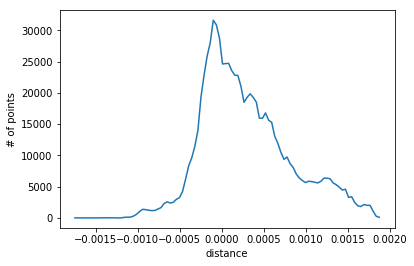

In [9]:
indics = ic.indicators(aggregate_coord, bounding_ellipsoid, middle_ellipsoid, included_ellipsoid,
              tomo_surface, tomo_volume, scale_maxvalue=0.004, sigma=5)